17. Regress the number of facilities to both the number of daily trains and number of daily
travelers. Do this using two univariate regressions and determine which covariate is the
primary driver for number of facilities, based on the adequate goodness-of-fit measure.

In [3]:
import pandas as pd
import statsmodels.api as sm
from pathlib import Path
import numpy as np
import src.utils as utils
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.core.pylabtools import figsize
import src.data_processing.data as data
from sklearn.preprocessing import MinMaxScaler

In [4]:
#Get total number of facilities per station:
facil_col = ['ticket_vending_machine', 'luggage_lockers', 'free_parking', 'taxi', 'bicycle_spots', 'blue-bike',
             'bus', 'tram', 'metro', 'wheelchair_available', 'ramp', 'disabled_parking_spots', 'elevated_platform',
             'escalator_up', 'escalator_down', 'elevator_platform', 'audio_induction_loop']
# PROBLEM: disabled_parking_spots is the number of spots instead of a dummy indicator
# so let's create a dummy variable
data.facilities['disabled_parking_spots_indicator'] = np.where(data.facilities['disabled_parking_spots']==0,0,1)
# drop old variable and add new name to our list
facil_col.remove('disabled_parking_spots')
facil_col = facil_col + ['disabled_parking_spots_indicator']
# compute total number of facilities per station
data.facilities['number_facilities'] = data.facilities[facil_col].sum(axis = 1)
data.facilities['number_facilities']

2      12.0
3       1.0
4       7.0
5       9.0
6       1.0
       ... 
668     3.0
669     3.0
670     8.0
672     3.0
673     4.0
Name: number_facilities, Length: 557, dtype: float64

In [5]:
## Number of daily travelers
# create total
data.travelers["week_total"] = 5 * data.travelers["week"] + data.travelers["saturday"] + data.travelers["sunday"]
data.travelers["avg_day"] = data.travelers["week_total"] / float(7)
merge = pd.merge(data.facilities, data.travelers, left_on='name', right_on='Station')
data.travelers
merge


,URI,name,street,zip,city,ticket_vending_machine,luggage_lockers,free_parking,taxi,bicycle_spots,...,disabled_parking_spots_indicator,number_facilities,Unnamed: 0,Station,week,saturday,sunday,sum,week_total,avg_day
0,008895000,aalst,Stationsplein 9,9300,Aalst,1.0,0.0,1.0,1.0,1.0,...,1,12.0,0,aalst,6444.0,1768.0,1592.0,9804.0,35580.0,5082.857143
1,008895125,aalst-kerrebroek,Ledebaan,9300,Aalst,0.0,0.0,1.0,0.0,0.0,...,0,1.0,1,aalst-kerrebroek,27.0,0.0,0.0,NaN,135.0,19.285714
2,008891140,aalter,Stationsplein 2,9880,Aalter,1.0,0.0,1.0,0.0,1.0,...,1,7.0,2,aalter,2288.0,1055.0,855.0,4198.0,13350.0,1907.142857
3,008833209,aarschot,Statieplein,3200,Aarschot,1.0,0.0,1.0,0.0,1.0,...,1,9.0,3,aarschot,6270.0,1954.0,1395.0,9619.0,34699.0,4957.000000
4,008892288,aarsele,Hogenhovenstraat Zn,8700,Aarsele,1.0,0.0,0.0,0.0,0.0,...,0,1.0,4,aarsele,34.0,0.0,0.0,NaN,170.0,24.285714
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
545,008832250,zolder,Stationsstraat Z/n,3550,Heusden - Zolder,1.0,0.0,1.0,0.0,0.0,...,1,3.0,549,zolder,123.0,38.0,37.0,198.0,690.0,98.571429
546,008832334,zonhoven,Engstegenseweg,3520,Zonhoven,1.0,0.0,1.0,0.0,0.0,...,1,3.0,550,zonhoven,67.0,29.0,19.0,115.0,383.0,54.714286
547,008895208,zottegem,Stationsplein 12,9620,Zottegem,1.0,0.0,1.0,0.0,1.0,...,1,8.0,551,zottegem,4936.0,986.0,931.0,6853.0,26597.0,3799.571429
548,008894821,zwijndrecht,Fortlaan 1,2070,Zwijndrecht,1.0,0.0,1.0,0.0,1.0,...,0,3.0,552,zwijndrecht,401.0,43.0,44.0,488.0,2092.0,298.857143


In [7]:
#First we need to do scaling in order to be able to compare daily travelers with daily trains:
scaler = MinMaxScaler()
scaler.fit(merge[['avg_day', 'number_facilities']])
merge[['avg_day', 'number_facilities']] = scaler.transform(merge[['avg_day', 'number_facilities']])
#univariate regression for daily travelers:
X = merge['avg_day']
Y = merge['number_facilities']
X = sm.add_constant(X) # adding a constant: Y = beta0 + beta1*X1 + beta2*X2 + espilon instead of Y = beta1*X1 + beta2*X2 + epsilon

model = sm.OLS(Y, X).fit()
print_model = model.summary()
print_model

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:      number_facilities   R-squared:                       0.337
Model:                            OLS   Adj. R-squared:                  0.336
Method:                 Least Squares   F-statistic:                     278.4
Date:                Sun, 06 Nov 2022   Prob (F-statistic):           7.63e-51
Time:                        16:08:28   Log-Likelihood:                 264.57
No. Observations:                 550   AIC:                            -525.1
Df Residuals:                     548   BIC:                            -516.5
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.2113      0.007     31.885      0.000       0.198       0.224
avg_day        1.1118      0.067     16.685      0.000       0.981       1.243
==============================================================================
Omnibus:                       24.982   Durbin-Watson:                   1.977
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               27.170
Skew:                           0.535   Prob(JB):                     1.26e-06
Kurtosis:                       3.203   Cond. No.                         10.4
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [8]:
## Number of daily trains
trips = data.full_trips
daily_trains = trips["Name of the stop"].value_counts().reset_index().rename(columns={"index": "Name of the stop", "Name of the stop": "count"}).astype({"count": int})
daily_trains['count_perDay'] = daily_trains["count"]/7
daily_trains

,Name of the stop,count,count_perDay
0,brussel-zuid/bruxelles-midi,7421,1060.142857
1,brussel-noord/bruxelles-nord,6899,985.571429
2,brussel-kapellekerk/bruxelles-chapelle,6892,984.571429
3,brussel-centraal/bruxelles-central,6892,984.571429
4,brussel-congres/bruxelles-congrès,6892,984.571429
...,...,...,...
622,oostende-zeehaven,3,0.428571
623,leuven-bundel m,2,0.285714
624,hasselt-aflos l.35/1,1,0.142857
625,gent-sint-pieters-bundels,1,0.142857


In [9]:
## merge: when we want to merge, we see that there are 4 stations in facilities that are not in full_trips:
## antwerpen-haven, bastogne-nord, bastogne-sud and florée. These are 4 stations that are permanently closed now, so it is not interesting to take these stations into consideration
## Hence, we will merge the same stations in full trips with facilities as we did for travelers
len(list(set(data.facilities['name']).intersection(set(daily_trains['Name of the stop']))))
intersection = list(set(data.facilities['name']).intersection(set(daily_trains['Name of the stop'])))
still_needed = set(data.facilities['name']).difference(intersection)
still_needed

{'antwerpen-haven', 'bastogne-nord', 'bastogne-sud', 'florée'}

In [10]:
merge_trains = pd.merge(data.facilities, daily_trains, left_on= 'name', right_on= 'Name of the stop')
merge_trains

,URI,name,street,zip,city,ticket_vending_machine,luggage_lockers,free_parking,taxi,bicycle_spots,...,sales_close_friday,sales_open_saturday,sales_close_saturday,sales_open_sunday,sales_close_sunday,disabled_parking_spots_indicator,number_facilities,Name of the stop,count,count_perDay
0,008895000,aalst,Stationsplein 9,9300,Aalst,1.0,0.0,1.0,1.0,1.0,...,0 days 20:00:00,0 days 06:00:00,0 days 20:00:00,0 days 06:00:00,0 days 20:00:00,1,12.0,aalst,1262,180.285714
1,008895125,aalst-kerrebroek,Ledebaan,9300,Aalst,0.0,0.0,1.0,0.0,0.0,...,0 days 00:00:00,0 days 00:00:00,0 days 00:00:00,0 days 00:00:00,0 days 00:00:00,0,1.0,aalst-kerrebroek,70,10.000000
2,008891140,aalter,Stationsplein 2,9880,Aalter,1.0,0.0,1.0,0.0,1.0,...,0 days 14:15:00,0 days 07:45:00,0 days 15:00:00,0 days 07:45:00,0 days 15:00:00,1,7.0,aalter,1285,183.571429
3,008833209,aarschot,Statieplein,3200,Aarschot,1.0,0.0,1.0,0.0,1.0,...,0 days 20:00:00,0 days 06:00:00,0 days 20:00:00,0 days 07:00:00,0 days 14:15:00,1,9.0,aarschot,1250,178.571429
4,008892288,aarsele,Hogenhovenstraat Zn,8700,Aarsele,1.0,0.0,0.0,0.0,0.0,...,0 days 00:00:00,0 days 00:00:00,0 days 00:00:00,0 days 00:00:00,0 days 00:00:00,0,1.0,aarsele,268,38.285714
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
548,008832250,zolder,Stationsstraat Z/n,3550,Heusden - Zolder,1.0,0.0,1.0,0.0,0.0,...,0 days 00:00:00,0 days 00:00:00,0 days 00:00:00,0 days 00:00:00,0 days 00:00:00,1,3.0,zolder,217,31.000000
549,008832334,zonhoven,Engstegenseweg,3520,Zonhoven,1.0,0.0,1.0,0.0,0.0,...,0 days 00:00:00,0 days 00:00:00,0 days 00:00:00,0 days 00:00:00,0 days 00:00:00,1,3.0,zonhoven,217,31.000000
550,008895208,zottegem,Stationsplein 12,9620,Zottegem,1.0,0.0,1.0,0.0,1.0,...,0 days 20:00:00,0 days 07:15:00,0 days 14:30:00,0 days 07:15:00,0 days 14:30:00,1,8.0,zottegem,974,139.142857
551,008894821,zwijndrecht,Fortlaan 1,2070,Zwijndrecht,1.0,0.0,1.0,0.0,1.0,...,0 days 00:00:00,0 days 00:00:00,0 days 00:00:00,0 days 00:00:00,0 days 00:00:00,0,3.0,zwijndrecht,827,118.142857


In [11]:
#First we need to do scaling in order to be able to compare daily travelers with daily trains:
scaler = MinMaxScaler()
scaler.fit(merge_trains[['count_perDay', 'number_facilities']])
merge_trains[['count_perDay', 'number_facilities']] = scaler.transform(merge_trains[['count_perDay', 'number_facilities']])
#univariate regression for daily travelers:
X = merge_trains['count_perDay']
Y = merge_trains['number_facilities']
X = sm.add_constant(X) # adding a constant: Y = beta0 + beta1*X1 + beta2*X2 + espilon instead of Y = beta1*X1 + beta2*X2 + epsilon

model = sm.OLS(Y, X).fit()
print_model = model.summary()
print_model

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:      number_facilities   R-squared:                       0.178
Model:                            OLS   Adj. R-squared:                  0.177
Method:                 Least Squares   F-statistic:                     119.6
Date:                Sun, 06 Nov 2022   Prob (F-statistic):           2.47e-25
Time:                        16:08:41   Log-Likelihood:                 206.85
No. Observations:                 553   AIC:                            -409.7
Df Residuals:                     551   BIC:                            -401.1
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
================================================================================
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
const            0.1732      0.009     18.555      0.000       0.155       0.192
count_perDay     0.6676      0.061     10.938      0.000       0.548       0.788
==============================================================================
Omnibus:                       39.538   Durbin-Watson:                   1.886
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               49.182
Skew:                           0.613   Prob(JB):                     2.09e-11
Kurtosis:                       3.794   Cond. No.                         8.69
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

As we see the daily travelers Adj R² = 0.336 while the Adj R² for daily trains is only 0.177. Based on this goodness-of-fit measure we can say that daily travelers will be more a primary driver than daily trains. This is quite logical because the number of facilities is important for travelers. If you have a lot of trains but each time with a low amount of travelers, than the number of facilities will be less important than if you have a lot of travelers travelling in less trains.

EXTRA INSIGHT: regress total sum of delay time per station for total travelers of that station

In [32]:
stations_total_delay_time = trips.groupby("Name of the stop")["Delay time"].sum().reset_index().rename(columns={"Delay time": "Total delay time"})
stations_total_delay_time
merged = pd.merge(data.travelers, stations_total_delay_time, left_on = 'Station', right_on='Name of the stop')
merged

,Unnamed: 0,Station,week,saturday,sunday,sum,week_total,avg_day,Name of the stop,Total delay time
0,0,aalst,6444.0,1768.0,1592.0,9804.0,35580.0,5082.857143,aalst,132524
1,1,aalst-kerrebroek,27.0,0.0,0.0,NaN,135.0,19.285714,aalst-kerrebroek,3209
2,2,aalter,2288.0,1055.0,855.0,4198.0,13350.0,1907.142857,aalter,117825
3,3,aarschot,6270.0,1954.0,1395.0,9619.0,34699.0,4957.000000,aarschot,79891
4,4,aarsele,34.0,0.0,0.0,NaN,170.0,24.285714,aarsele,34880
...,...,...,...,...,...,...,...,...,...,...
548,548,zingem,523.0,98.0,86.0,707.0,2799.0,399.857143,zingem,26349
549,549,zolder,123.0,38.0,37.0,198.0,690.0,98.571429,zolder,24187
550,550,zonhoven,67.0,29.0,19.0,115.0,383.0,54.714286,zonhoven,27674
551,551,zottegem,4936.0,986.0,931.0,6853.0,26597.0,3799.571429,zottegem,77810


In [33]:
#scaler = MinMaxScaler()
#scaler.fit(merged[['week_total', 'Total delay time']])
#merged[['week_total', 'Total delay time']] = scaler.transform(merged[['week_total', 'Total delay time']])
#univariate regression for total travelers:
X = merged['week_total']
Y = merged['Total delay time']
X = sm.add_constant(X) # adding a constant: Y = beta0 + beta1*X1 + beta2*X2 + espilon instead of Y = beta1*X1 + beta2*X2 + epsilon

model = sm.OLS(Y, X).fit()
print_model = model.summary()
print_model

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:       Total delay time   R-squared:                       0.396
Model:                            OLS   Adj. R-squared:                  0.395
Method:                 Least Squares   F-statistic:                     361.6
Date:                Sun, 06 Nov 2022   Prob (F-statistic):           2.28e-62
Time:                        16:31:02   Log-Likelihood:                -7100.4
No. Observations:                 553   AIC:                         1.420e+04
Df Residuals:                     551   BIC:                         1.421e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const       7.092e+04   4029.443     17.600      0.000     6.3e+04    7.88e+04
week_total     2.1089      0.111     19.016      0.000       1.891       2.327
==============================================================================
Omnibus:                      527.764   Durbin-Watson:                   1.578
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            24153.646
Skew:                           4.115   Prob(JB):                         0.00
Kurtosis:                      34.313   Cond. No.                     3.77e+04
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 3.77e+04. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

C:\Users\jonav\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<Figure size 400x300 with 0 Axes>

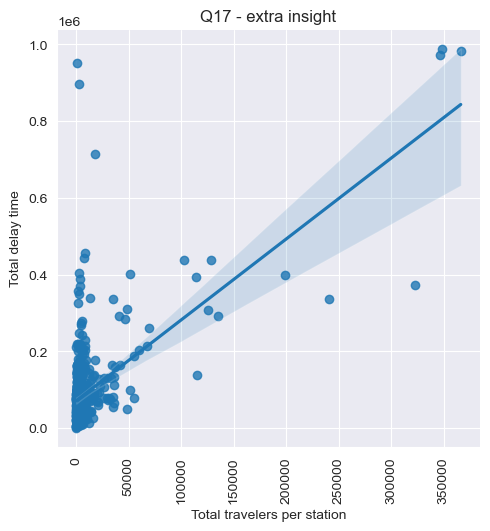

In [35]:
plt.figure(figsize=(4,3), facecolor="white")
sns.lmplot('week_total', 'Total delay time', data = merged, fit_reg=True)
plt.title("Q17 - extra insight")
plt.xlabel("Total travelers per station")
plt.ylabel("Total delay time")
plt.xticks(rotation="vertical")
plt.show()